In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
import matplotlib.tri
import okada_wrapper
import tectosaur as tct

In [17]:
TCTN = 61
CURVE = 1.0

corners = [[-1, 0, -1], [1, 0, -1], [1, 0, 1], [-1, 0, 1]]
src_mesh = tct.make_rect(TCTN, TCTN, corners)
src_mesh[0][:,1] = CURVE * np.abs(src_mesh[0][:,0])
#src_mesh[0][:,1] = CURVE * (src_mesh[0][:,0] ** 2 + src_mesh[0][:,2] ** 2)
def gauss_slip_fnc(x, z):
    r2 = x ** 2 + z ** 2
    R = 0.5
    out = (np.cos(np.sqrt(r2) * np.pi / R) + 1) / 2.0
    out[np.sqrt(r2) > R] = 0.0
    return out
dof_pts = src_mesh[0][src_mesh[1]]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((src_mesh[1].shape[0], 3, 3)).astype(np.float32)
slip[:,:,0] = gauss_slip_fnc(x, z)

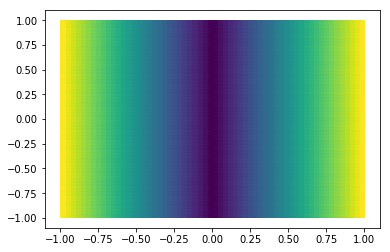

In [18]:
plt.tripcolor(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1], src_mesh[0][:,1])
plt.show()

In [19]:
H = tct.RegularizedSparseIntegralOp(
    6, 6, 6, 2, 5, 2.5,
    'elasticRH3', 'elasticRH3', [1.0, 0.25], src_mesh[0], src_mesh[1], np.float32,
    farfield_op_type = tct.TriToTriDirectFarfieldOp
)

[9766657:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[9766660:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[9766663:DEBUG:tectosaur.nearfield.nearfield_op]
         setup pairs integrator took 0.006520259979879484
[9768818:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident took 2.153552675008541
[9768843:DEBUG:tectosaur.nearfield.nearfield_op]
         Coincident correction took 0.02438005097792484
[9769030:DEBUG:tectosaur.nearfield.nearfield_op]
         Find nearfield/adjacency took 0.1865283570077736
[9776099:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent took 7.068527878000168
[9776125:DEBUG:tectosaur.nearfield.nearfield_op]
         Edge adjacent correction took 0.025554674997692928
[9784772:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent took 8.645991327997763
[9784809:DEBUG:tectosaur.nearfield.nearfield_op]
         Vert adjacent correction took 0.036035052995430306
[9787559:DEBUG:tectosau

In [20]:
traction_mass_op = tct.MassOp(4, src_mesh[0], src_mesh[1])

In [21]:
dof_pts = src_mesh[0][src_mesh[1]]
from tectosaur.util.geometry import unscaled_normals
ns = unscaled_normals(dof_pts)
ns /= np.linalg.norm(ns, axis = 1)[:, np.newaxis]
ns = np.repeat(ns, 3, axis = 0)

In [22]:
edge_dofs = tct.free_edge_dofs(src_mesh[1], tct.find_free_edges(src_mesh[1]))

In [23]:
obs_pts = dof_pts.reshape((-1,3))[edge_dofs]
obs_ns = ns[edge_dofs]
interior_op = tct.InteriorOp(obs_pts.copy(), obs_ns.copy(), src_mesh, 'elasticH3', 10, 6, 6, [1.0, 0.25], np.float32)

[9788166:DEBUG:tectosaur.util.gpu]
    returning cached gpu module matrix_free.cl
[9788179:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[9788209:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl
[9788240:DEBUG:tectosaur.util.gpu]
    returning cached gpu module assemble.cl


In [24]:
trac_edges = -interior_op.dot(slip.flatten())

In [25]:
vec_edge_dofs = np.tile(3 * np.array(edge_dofs)[:,np.newaxis], (1,3))
vec_edge_dofs[:,1] += 1
vec_edge_dofs[:,2] += 2
vec_edge_dofs = vec_edge_dofs.flatten()

In [26]:
cs1 = tct.continuity_constraints(src_mesh[0], src_mesh[1], src_mesh[1].shape[0])
# cs12 = cs1
#cs1 = tct.traction_admissibility_constraints(src_mesh[0], src_mesh[1], slip, 1.0)
cs = cs1 + tct.simple_constraints(vec_edge_dofs, trac_edges)

In [27]:
cm, c_rhs, c_rhs_mat = tct.build_constraint_matrix(cs, src_mesh[1].shape[0] * 9)

In [28]:
constrained_traction_mass_op = cm.T.dot(traction_mass_op.mat.dot(cm))

rhs = -cm.T.dot(H.dot(slip.flatten())) - cm.T.dot(traction_mass_op.mat.dot(c_rhs))
#rhs = -cm.T.dot(traction_mass_op.mat.dot(c_rhs2))
soln = cg(constrained_traction_mass_op, rhs)
out = cm.dot(soln[0]) + c_rhs

[9789541:DEBUG:tectosaur.ops.sparse_integral_op]
    start farfield_dot
[9790656:DEBUG:tectosaur.ops.sparse_integral_op]
     farfield_dot took 1.1152669629955199
[9790657:DEBUG:tectosaur.ops.sparse_integral_op]
    start nearfield_dot
[9790689:DEBUG:tectosaur.ops.sparse_integral_op]
     nearfield_dot took 0.03164484800072387


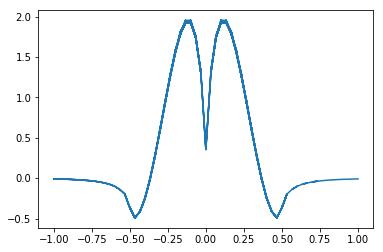

In [29]:
pts = src_mesh[0][src_mesh[1]].reshape((-1,3))
idxs = np.where(np.abs(pts[:,2]) < 0.05)[0]
#idxs = np.where(np.abs(pts[:,0]) < 0.01)[0]
plt.plot(pts[idxs][:,0], out.reshape((-1,3))[idxs][:,0])
plt.show()

/home/tbent/.virtualenvs/tectosaur/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


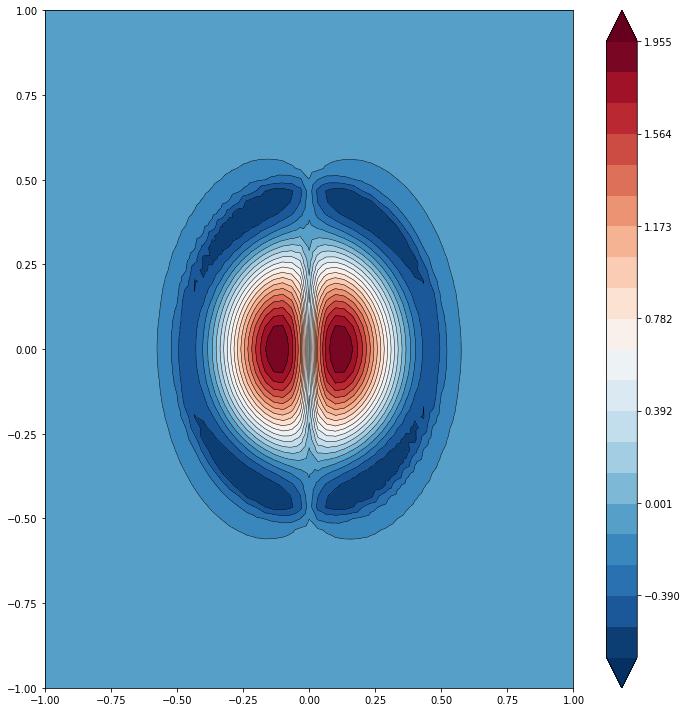

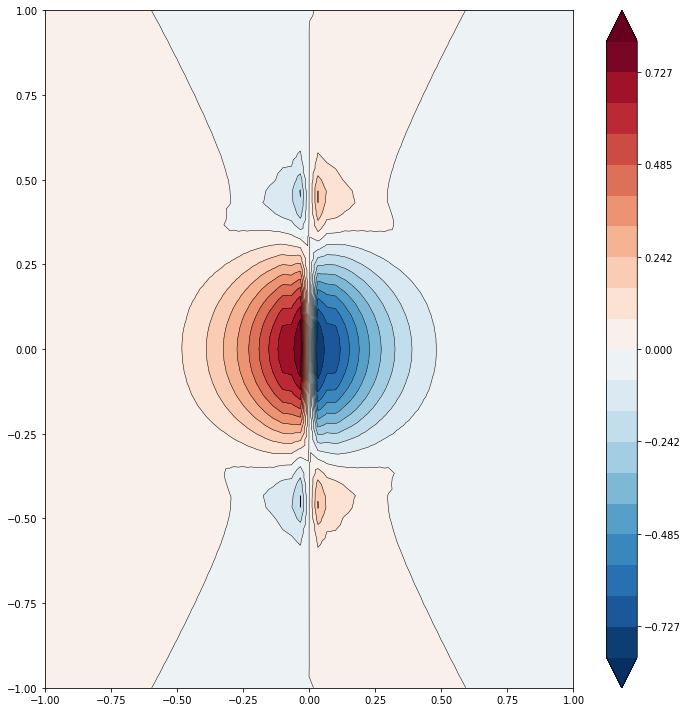

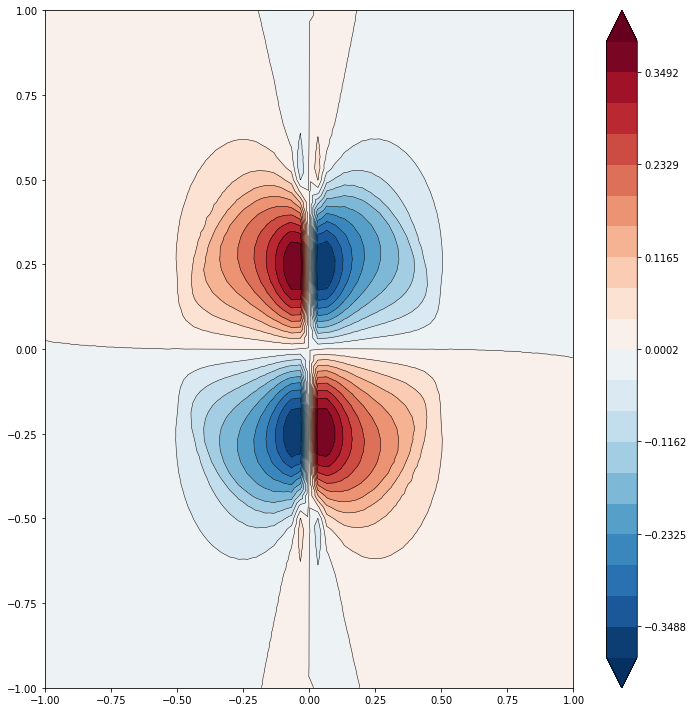

In [30]:
tri_centers = np.mean(src_mesh[0][src_mesh[1]], axis = 1)

side = np.zeros(src_mesh[1].shape[0]).astype(np.int)
#side[tri_centers[:,0] > 0] = 1

cmap = 'RdBu_r'

levels = [
    np.linspace(-0.3, 1.0, 21),
    np.linspace(-1.9, 1.9, 21),
    np.linspace(-0.6, 0.6, 21)
]
levels = []
for d in range(3):
    minf = np.min(out.reshape((-1,3))[:,d])
    maxf = np.max(out.reshape((-1,3))[:,d])
    levels.append(np.linspace(minf - 1e-12, maxf + 1e-12, 21))

for d in range(3):
    
    field = out.reshape((-1,3,3))[:,:,d]
    #field = np.tile(side[:,np.newaxis], (1,3))
    plt.figure(figsize = (10,10))
    
    # This is the critical section of code. We take all the triangles except one of the fault touching 
    # sides and make a contour plot with them. The combination of the two contour plots results in a 
    # nice clean edge.
    for i in range(1):
        which_tris = np.where(side == i)[0]
        reduced_m = tct.mesh.modify.remove_unused_pts((src_mesh[0], src_mesh[1][which_tris]))
        soln_vals = np.empty(reduced_m[0].shape[0])
        soln_vals[reduced_m[1]] = field[which_tris]
        
        cntf = plt.tricontourf(
            reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
            cmap = cmap, linewidth = 0.5, levels = levels[d], extend = 'both'
        )
        plt.tricontour(
            reduced_m[0][:,0], reduced_m[0][:,2], reduced_m[1], soln_vals, 
            linestyles = 'solid', colors='k', linewidths = 0.5, levels = levels[d]
        )
        
    plt.colorbar(cntf)
    plt.tight_layout()
    plt.show()

In [18]:
# for i in range(10):
#     C1 = cs12[i]
#     C2 = cs1[i]
#     print((C1.terms[0].dof, C1.terms[0].val), (C1.terms[1].dof, C1n.terms[1].val))
#     print((C2.terms[0].dof, C2.terms[0].val), (C2.terms[1].dof, C2.terms[1].val))

# plt.plot(obs_pts[:,0], trac_edges.reshape((-1,3))[:,0], '.')
# plt.show()

In [19]:
# def plot_fnc(triang, f):
#     levels = np.linspace(-np.max(f) - 1e-12, np.max(f) + 1e-12, 9)
#     #levels = np.linspace(-0.2, 0.2, 31)
#     cntf = plt.tricontourf(triang, f, levels = levels, cmap = 'RdBu_r')
#     #plt.tricontour(triang, f, levels = levels, linestyles = 'solid', colors = 'k', linewidths = 0.5)
#     plt.colorbar(cntf)

# triang = matplotlib.tri.Triangulation(src_mesh[0][:,0], src_mesh[0][:,2], src_mesh[1])
# plt.figure(figsize = (25,8))
# for d in range(3):
#     f = out.reshape((-1,3,3))[:,:,d]
#     f_pts = np.zeros(src_mesh[0].shape[0])
#     f_pts[src_mesh[1]] = f
#     plt.subplot(1, 3, d + 1)
#     plot_fnc(triang, f_pts)
# plt.show()